### **Import required packages**

In [9]:
import os
import math
import glob
import time
import cv2
import random
from datetime import datetime
import pickle
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from skimage.feature import hog
from skimage import filters

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn import tree

from scipy.ndimage import label

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Utility Functions to convert color space and plot image**

In [10]:
# Hold the color code name and opencv objects in a dict for easy conversion
colorCodeDict = {
    'RGB2GRAY' : cv2.COLOR_RGB2GRAY,
    'RGB2RGBA' : cv2.COLOR_RGB2RGBA,
    'RGB2BGR' : cv2.COLOR_RGB2BGR,
    'RGB2BGRA' : cv2.COLOR_RGB2BGRA,
    'RGB2HSV' : cv2.COLOR_RGB2HSV,
    'RGB2HLS' : cv2.COLOR_RGB2HLS,
    'RGB2LUV' : cv2.COLOR_RGB2LUV,
    'RGB2YUV' : cv2.COLOR_RGB2YUV,
    'RGB2YCrCb' : cv2.COLOR_RGB2YCrCb,

    'BGR2GRAY' : cv2.COLOR_BGR2GRAY,
    'BGR2BGRA' : cv2.COLOR_BGR2BGRA,
    'BGR2RGB' : cv2.COLOR_BGR2RGB,
    'BGR2RGBA' : cv2.COLOR_BGR2RGBA,
    'BGR2HSV' : cv2.COLOR_BGR2HSV,
    'BGR2HLS' : cv2.COLOR_BGR2HLS,
    'BGR2LUV' : cv2.COLOR_RGB2LUV,
    'BGR2YUV' : cv2.COLOR_RGB2YUV,
    'BGR2YCrCb' : cv2.COLOR_RGB2YCrCb
}

def convert_color(img , convCode='RGB2GRAY'):
    """
        return image converted to required colospace
    """
    return cv2.cvtColor(img, colorCodeDict[convCode]);

def plot_img(img, show_stages=False, label="", cmap='gray'):
    """
        plot image
    """
    if show_stages:
        print("############################# "+ label +" ##################################")
        plt.figure(figsize = (5,5))
        plt.imshow(img, cmap=cmap)
        plt.show()

### **Set prameters to be used for training the classifier and predictions**

In [11]:
colorConv = "RGB2YCrCb"
orient = 9
spatial_size = (16, 16)
hist_bins = 32
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
recent_heatmaps = deque(maxlen=10)
spatial_feat = True
hist_feat = True
hog_feat = True

### **Functions to extract different image features**

In [12]:
def bin_spatial(image, size=(32, 32)):
    """
        Return the image color bins
    """
    # Create the feature vector
    spatial_vector = cv2.resize(image, size).ravel()
    return spatial_vector

def color_hist(image, nbins=32):
    """
        Return all channel histogram.
    """
    # Compute the histogram of the color channels separately
    hist_vector = np.array([])
    for channel in range(image.shape[2]):
        channel_hist = np.histogram(image[:, :, channel],
                bins=nbins, range=(0, 255))[0]
        hist_vector = np.hstack((hist_vector, channel_hist))
    return hist_vector

def get_hog_features(image, orient, feature_vector=True):
    """
        Return a histogram of oriented gradients using skimage.
    """
    multichannel = len(image.shape) > 2
    if multichannel:
      sk_hog_vector = hog(image, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True,
                       channel_axis=-1, feature_vector=feature_vector)
    else:
      sk_hog_vector = hog(image, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True,
                       feature_vector=feature_vector)
    return sk_hog_vector

### **Wrapper function to extract and combine different features**

In [13]:
def getFeatureVector(image, hog_features=True, hist_features=True, spatial_features=True, hog_bins=9, hist_bins=16,
        spatial_size=(16,16)):

        """Return the feature vector for an image."""
        feature_vector = np.array([])

        if hog_features:
          feature_vector = np.hstack((feature_vector, np.ravel(get_hog_features(image, hog_bins, feature_vector=True))))

        if hist_features:
          feature_vector = np.hstack((feature_vector, color_hist(image, hist_bins)))

        if spatial_features:
          feature_vector = np.hstack((feature_vector, bin_spatial(image, spatial_size)))

        return feature_vector

### **Process the image files to extract features and create feature vector**

In [14]:
def processFiles(pos_dir, neg_dir, recurse=False, conv_code='RGB2GRAY', channels=[0, 1, 2],
        output_filename=None, hog_lib="cv", hog_bins=9, block_stride=None, block_norm="L1",
        transform_sqrt=True, signed_gradient=False, hist_bins=16,
        spatial_size=(16,16)):

    """
    Extract features from positive samples and negative samples.
    Store feature vectors in a dict and save to pickle file.
    """

    pos_dir = os.path.abspath(pos_dir)
    neg_dir = os.path.abspath(neg_dir)

    if not os.path.isdir(pos_dir):
        raise FileNotFoundError("Directory " + pos_dir + " does not exist.")
    if not os.path.isdir(neg_dir):
        raise FileNotFoundError("Directory " + neg_dir + " does not exist.")

    print("Building file list...")
    if recurse:
        pos_files = [os.path.join(rootdir, file) for rootdir, _, files
            in os.walk(pos_dir) for file in files]
        neg_files = [os.path.join(rootdir, file) for rootdir, _, files
            in os.walk(neg_dir) for file in files]
    else:
        pos_files = [os.path.join(pos_dir, file) for file in
            os.listdir(pos_dir) if os.path.isfile(os.path.join(pos_dir, file)) and file.endswith(".png")]
        neg_files = [os.path.join(neg_dir, file) for file in
            os.listdir(neg_dir) if os.path.isfile(os.path.join(neg_dir, file)) and file.endswith(".png")]

    print("{} positive files and {} negative files found.\n".format(
        len(pos_files), len(neg_files)))

    channel_index_str = str(channels[0])
    for ch_index in channels[1:]:
        channel_index_str += ", {}".format(ch_index)

    print("Converting images to " + conv_code + " color space and "
        + "extracting features from channel(s) "
        + channel_index_str + ".\n")

    pos_features = []
    neg_features = []
    start_time = time.time()

    # Iterate through files and extract features.
    for i, filepath in enumerate(pos_files + neg_files):
        if not filepath.endswith(".png"):
          continue
        image = cv2.imread(filepath)
        image = convert_color(image, conv_code)
        feature_vector = getFeatureVector(image, hog_bins, hist_bins, spatial_size)
        if i < len(pos_files):
            pos_features.append(feature_vector)
        else:
            neg_features.append(feature_vector)

    print("Features extracted from {} files in {:.1f} seconds\n".format(
        len(pos_features) + len(neg_features), time.time() - start_time))

    feature_data = {
                    "pos_features": pos_features,
                    "neg_features": neg_features
                    }
    if output_filename is None:
        output_filename = (datetime.now().strftime("%Y%m%d%H%M")
            + "_data.pkl")

    pickle.dump(feature_data, open(output_filename, "wb"))
    print("Sample and parameter data saved to {}\n".format(output_filename))

    return feature_data

### **Set up the train and test data**

In [15]:
def setup_train_data(features=None, filepath=None):

    """
        Set train set and test set from feature data extracted by processFiles().
    """
    print("Loading sample data.")
    if filepath is not None:
        filepath = os.path.abspath(filepath)
        if not os.path.isfile(filepath):
            raise FileNotFoundError("File " + filepath + " does not exist.")
        feature_data = pickle.load(open(filepath, "rb"))
    elif feature_data is None:
        raise ValueError("Invalid feature data supplied.")

    # Train classifier on training set.
    pos_features = np.asarray(feature_data["pos_features"])
    neg_features = np.asarray(feature_data["neg_features"])

    # Instantiate scaler and scale features.
    print("Scaling features.\n")
    # Create an array stack of feature vectors
    X = np.vstack((pos_features, neg_features)).astype(np.float64)
    print("Feature vector shape: ", X.shape)
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(pos_features)), np.zeros(len(neg_features))))
    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
      scaled_X, y, test_size=0.20, random_state=rand_state)

    # Split up data into randomized training and test sets
    return X_train, X_test, y_train, y_test, X_scaler

In [16]:
    pos_dir = "/content/drive/MyDrive/CarObjectDetection/binaryData/images/vehicles"
    neg_dir = "/content/drive/MyDrive/CarObjectDetection/binaryData/images/non-vehicles"

    feature_data_filename = "/content/drive/MyDrive/CarObjectDetection/binaryData/feature_data.pkl"

    # Extract HOG features from images in the sample directories and return
    # results and parameters in a dict.
    feature_data = processFiles(pos_dir, neg_dir, recurse=True,
          conv_code=colorConv, channels=[0,1,2], output_filename=feature_data_filename, hog_lib="cv",
          hog_bins=9, hist_bins=16, spatial_size=(16,16))

    print('Preparing training data...')
    X_train, X_test, y_train, y_test, X_scaler = setup_train_data(feature_data, feature_data_filename)
    print("Number of training examples =", len(X_train))
    print("Number of testing examples =", len(X_test))

Building file list...
5967 positive files and 9070 negative files found.

Converting images to RGB2YCrCb color space and extracting features from channel(s) 0, 1, 2.

Features extracted from 15034 files in 2921.3 seconds

Sample and parameter data saved to /content/drive/MyDrive/CarObjectDetection/binaryData/feature_data.pkl

Preparing training data...
Loading sample data.
Scaling features.

Feature vector shape:  (15034, 2580)
Number of training examples = 12027
Number of testing examples = 3007


### **Functions to train and test different classifiers**

In [29]:
def train_SVC(X_train, y_train):
    """
        Function to train an svm.
    """
    svc = svm.LinearSVC(C=50)
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    return svc

def test_classifier(svc, X_test, y_test):
    """
        Funtion to test the classifier.
    """
    t=time.time()
    y_pred = svc.predict(X_test)
    print('Trained classifier predicts: ', y_pred)
    print('Actual labels: ', y_test)
    print("Accuracy score of model is ",round(accuracy_score(y_pred=y_pred,y_true=y_test)*100, 2))
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict labels with SVC')

    # Model Precision: what percentage of positive tuples are labeled as such?
    print("Precision:", precision_score(y_test, y_pred))

    # Model Recall: what percentage of positive tuples are labelled as such?
    print("Recall:", recall_score(y_test, y_pred))

    print("F1 Score:", f1_score(y_test, y_pred))

    # Generate confusion matrix
    matrix = ConfusionMatrixDisplay.from_estimator(svc, X_test, y_test,
                                    cmap=plt.cm.Blues,
                                    normalize='true')
    plt.title('Confusion matrix for our classifier')
    plt.show(matrix)
    plt.show()


In [26]:
print('Training Classifier...')
svc = train_SVC(X_train, y_train)

output_filename = "/content/drive/MyDrive/CarObjectDetection/binaryData/classifier_data.pkl"
classifier_data = {}
classifier_data["classifier"] = svc

if output_filename is None:
    output_filename = (datetime.now().strftime("%Y%m%d%H%M") + "_classifier.pkl")
    pickle.dump(classifier_data, open(output_filename, "wb"))
    print("\nSVM classifier data saved to {}".format(output_filename))

Training Classifier...
2.89 Seconds to train SVC...


Testing Classifier...
Trained classifier predicts:  [1. 0. 0. ... 0. 0. 1.]
Actual labels:  [1. 0. 0. ... 0. 0. 1.]
Accuracy score of model is  99.7
0.0327 Seconds to predict labels with SVC
Precision: 0.9991721854304636
Recall: 0.9934156378600824
F1 Score: 0.9962855963681387


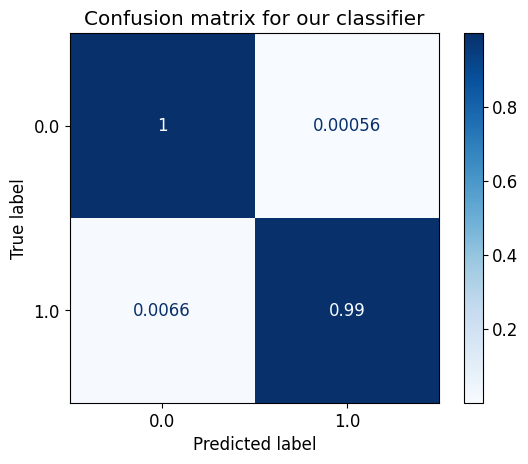

In [30]:
print('Testing Classifier...')
test_classifier(svc, X_test, y_test)
#test_classifier(clf, X_test, y_test)

### **Functions to remove duplicate detections and false positives by applying heatmap**

In [31]:
def add_heat(heatmap, bbox_list):
    """
        Iterate the windows with detected cars and enhance the once with highest detections.
    """
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap

def apply_threshold(heatmap, threshold):
    """
        Only keep the detections that have a minimum number of pixels.
    """
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_labeled_bboxes(img, labels):
    """
        Draw the boxes on the detected cars
    """
    for i in range(1, labels[1]+1):
        # Find pixels with each car label value
        nonzero = (labels[0] == i).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    return img

### **Detect cars using the trained classifier**

In [32]:
def find_cars(img, windows):
    """
        This function takes in an image, extracts the features from windows and
        runs the predictions on the features.
        Returns a list of co-ordinates where car is detected.
    """
    on_windows = []
    for window in windows:
        #3) Extract the test window from original image
        image = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        image = convert_color(image, colorConv)
        feature_vector = getFeatureVector(image, orient, 16, (16, 16))
        test_features = X_scaler.transform(feature_vector.reshape(1, -1))
        # make a prediction
        test_prediction = svc.predict(test_features)
        # Add to list of windows if car predicted
        if test_prediction == 1:
            on_windows.append(window)
    return on_windows

### **Create Silding windows to search an image for car object detection**

In [33]:
def slide_window(img, x_start_stop=[None, None],
                      y_start_stop=[None, None],
                      xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    """
        Function to get a list of windows to search on image.
    """
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    img = img[y_start_stop[0]:y_start_stop[1],:,:]
    img = convert_color(img, colorConv)

    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]

    # Compute the number of pixels per step in x/y
    nx_pix_per_step = int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = int(xy_window[1]*(1 - xy_overlap[1]))

    # Compute the number of windows in x/y
    nx_buffer = int(xy_window[0]*xy_overlap[0])
    ny_buffer = int(xy_window[1]*xy_overlap[1])
    nx_windows = int((xspan-nx_buffer)/nx_pix_per_step)
    ny_windows = int((yspan-ny_buffer)/ny_pix_per_step)

    # Initialize a list to append window positions to
    window_list = []

    # Loop through finding x and y window positions
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    return window_list


### **Wraper function to preprocess image run the classifier and post processing the result.**

In [34]:
def process_img(img, threshhold=1.5, show_stages=False):
    """
        Wrapper function to perform all the processing.
    """
    print("Test image shape is:", img.shape)
    # get the windows where the classifier predicts car
    # Crop the image to remove sky and car bonnet
    windows = slide_window(img, x_start_stop=[int(img.shape[1]*0.55), img.shape[1]],
                                y_start_stop=[int(img.shape[0]*0.55), int(img.shape[0]*0.9)],
                                xy_window=(64, 64), xy_overlap=(0.5, 0.5))

    hot_windows = find_cars(img, windows)
    if show_stages:
        img1 = np.copy(img)
        for bbox in hot_windows:
            cv2.rectangle(img1, bbox[0], bbox[1], (0,0,255), 6)
        plot_img(img1, show_stages, "All detections")

    # Highlight the windows
    heat = np.zeros_like(img[:,:,0]).astype(float)
    heat = add_heat(heat,hot_windows)
    plot_img(heat, show_stages, "After Applying heat", cmap='hot')

    # Append the detections to detections from last n frames
    recent_heatmaps.append(heat)

    # Take the mean of last n frames as discard the windows that are below the threshold
    heatmap = apply_threshold(np.mean(recent_heatmaps, axis=0),threshhold)
    plot_img(heatmap, show_stages, "After threshold", cmap='hot')

    # Add labels to remaning detections
    labels = label(heatmap)
    # Draw boxes on the cars and return the image
    return draw_labeled_bboxes(np.copy(img), labels)


### **Test on images**

/content/drive/MyDrive/CarObjectDetection/binaryData/test_images/

------------------------------/content/drive/MyDrive/CarObjectDetection/binaryData/test_images/test.jpg---------------------------------
Test image shape is: (1080, 1920, 3)
############################# All detections ##################################


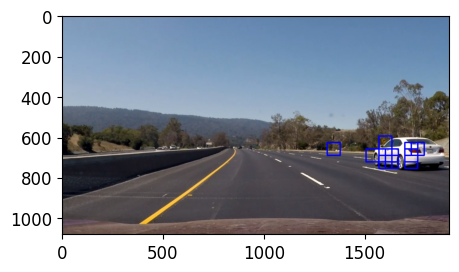

############################# After Applying heat ##################################


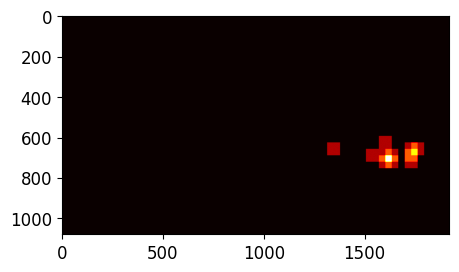

############################# After threshold ##################################


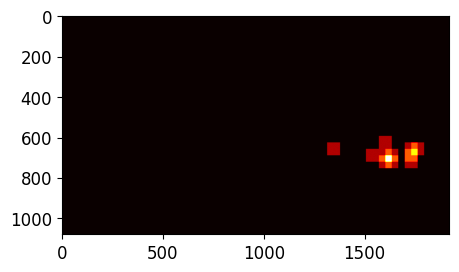

############################# Final Result ##################################


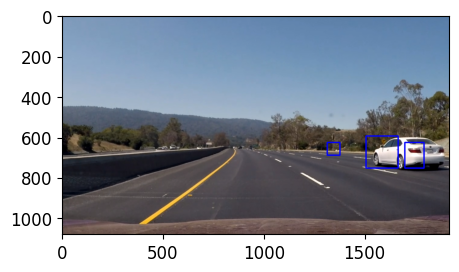



------------------------------/content/drive/MyDrive/CarObjectDetection/binaryData/test_images/test1.jpg---------------------------------
Test image shape is: (720, 1280, 3)
############################# All detections ##################################


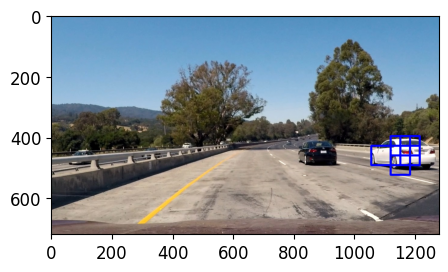

############################# After Applying heat ##################################


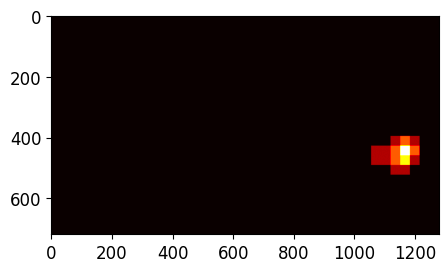

############################# After threshold ##################################


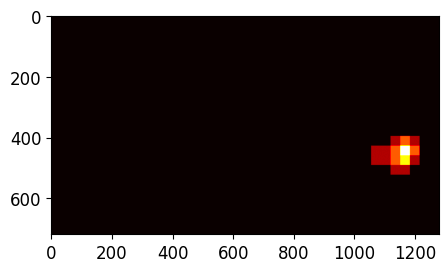

############################# Final Result ##################################


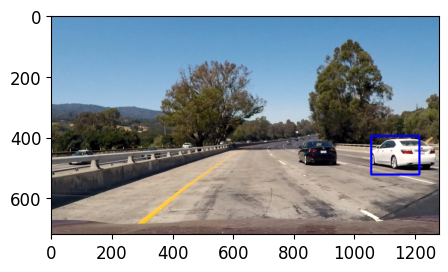



------------------------------/content/drive/MyDrive/CarObjectDetection/binaryData/test_images/test2.jpg---------------------------------
Test image shape is: (720, 1280, 3)
############################# All detections ##################################


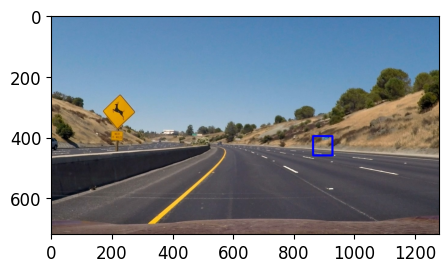

############################# After Applying heat ##################################


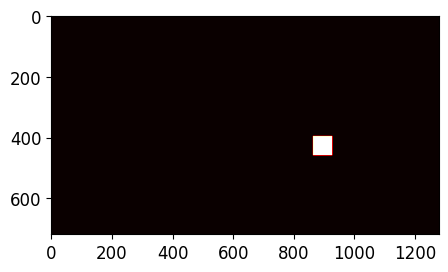

############################# After threshold ##################################


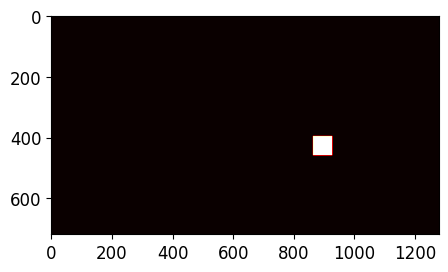

############################# Final Result ##################################


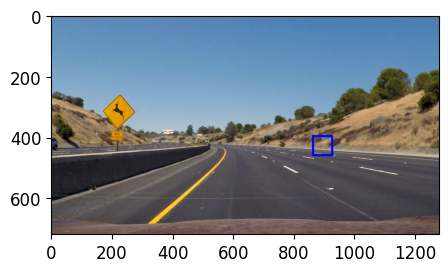



------------------------------/content/drive/MyDrive/CarObjectDetection/binaryData/test_images/test3.jpg---------------------------------
Test image shape is: (720, 1280, 3)
############################# All detections ##################################


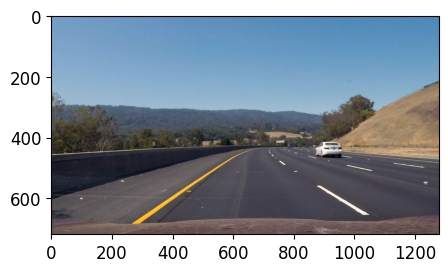

############################# After Applying heat ##################################


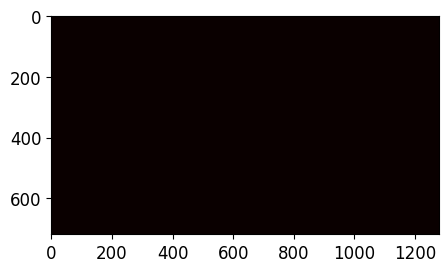

############################# After threshold ##################################


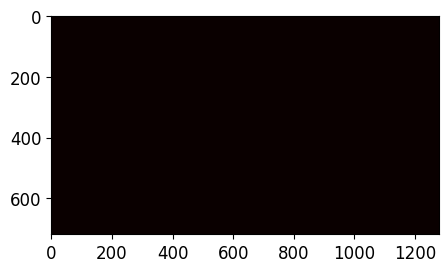

############################# Final Result ##################################


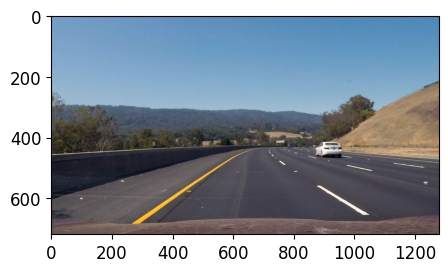



------------------------------/content/drive/MyDrive/CarObjectDetection/binaryData/test_images/test4.jpg---------------------------------
Test image shape is: (720, 1280, 3)
############################# All detections ##################################


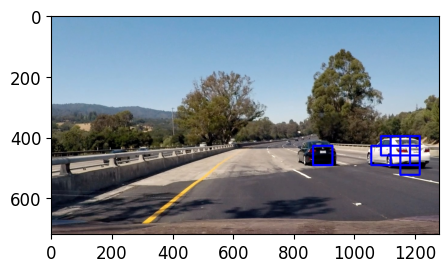

############################# After Applying heat ##################################


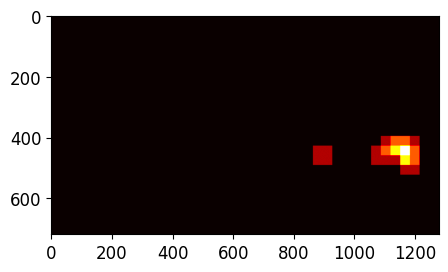

############################# After threshold ##################################


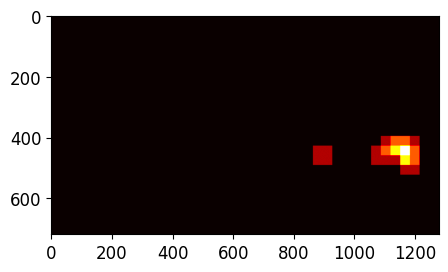

############################# Final Result ##################################


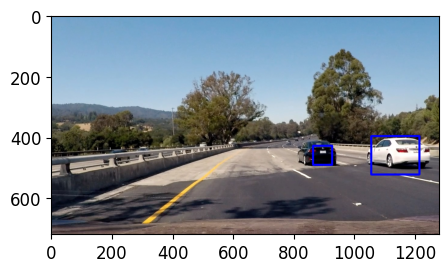



------------------------------/content/drive/MyDrive/CarObjectDetection/binaryData/test_images/test5.jpg---------------------------------
Test image shape is: (720, 1280, 3)
############################# All detections ##################################


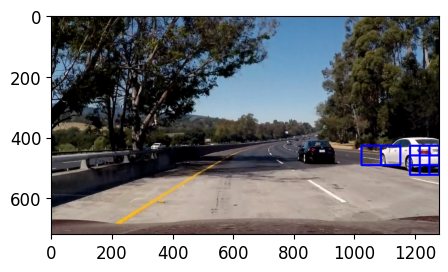

############################# After Applying heat ##################################


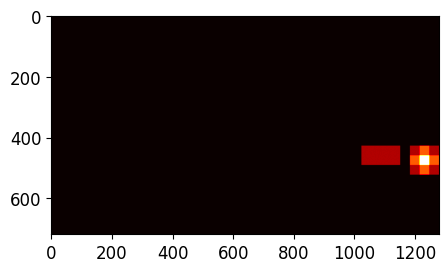

############################# After threshold ##################################


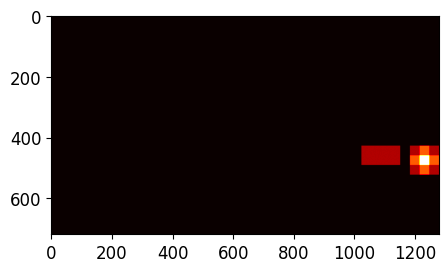

############################# Final Result ##################################


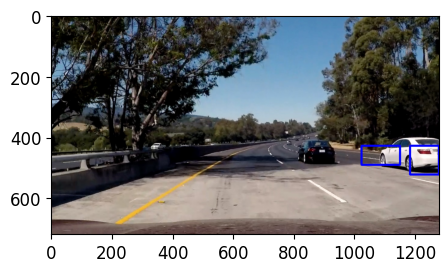



------------------------------/content/drive/MyDrive/CarObjectDetection/binaryData/test_images/test6.jpg---------------------------------
Test image shape is: (720, 1280, 3)
############################# All detections ##################################


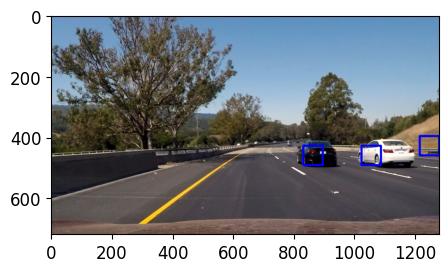

############################# After Applying heat ##################################


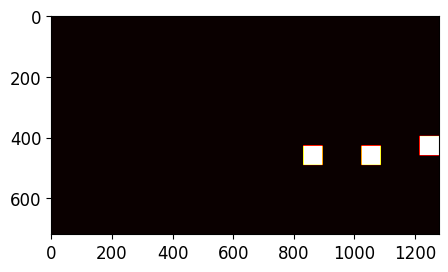

############################# After threshold ##################################


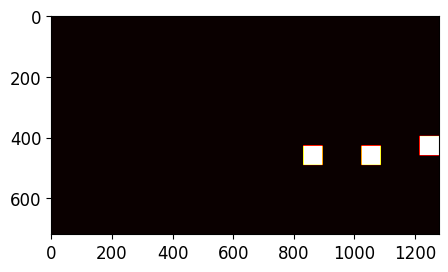

############################# Final Result ##################################


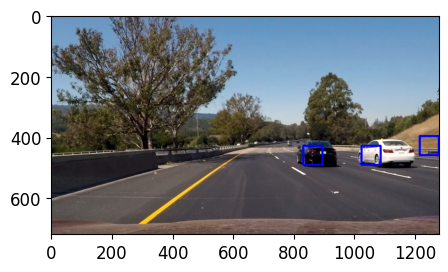

In [37]:
test_dir = "/content/drive/MyDrive/CarObjectDetection/binaryData/test_images/"
print(test_dir)
test_images = glob.glob(test_dir+'test*.jpg')
for test_image in test_images:
    print("")
    print("------------------------------"+test_image+"---------------------------------")
    recent_heatmaps = deque(maxlen=10)
    img = mpimg.imread(test_image)
    #plot_img(img, True, "Actual Image")
    out_img = process_img(img, 0.7, True)
    plot_img(out_img, True, "Final Result")
    print()